# ex01-Exploratory Flood Inundation Model with Flood Fill Algorithm

Flooding is a global phenomenon that causes casualties and property loss on every inhabited continent. It is probably the most devastating, widespread and frequent natural disaster for human societies. Flood inundation models are therefore developed to understand, assess and predict flood events and their impact (Teng et al., 2017). 

Empirical methods and hydrodynamic models are widely applied in flood inundation modelling. These flood models could be indeed valuable and useful. However, they are hard to be understood by people without strong background knowledge. We often hear on the news that a river is reaching the flood stage, but that information is meaningless if we can't understand the impact (Joel Lawhead, 2019). With free DEM data and open source geospatial tools, some exploratory models could be developed to check the impact of a flood under some fake scenarios.

In this notebook, a flood inundation model is presented based on a popular image processing technique, named Flood fill algorithm. Flood fill, also called seed fill, is an algorithm that determines the area connected to a given node in a multi-dimensional array. It is used in the "bucket" fill tool of paint programs to fill connected, similarly-colored areas with a different color, and in games such as Go and Minesweeper for determining which pieces are cleared. The Wikipedia article provides an excellent overview of [flood fill algorithms](https://en.wikipedia.org/wiki/Flood_fill). The algorithm is modified to run on an array created from the digital elevation model, and masked based on the starting point. 

The demo data is downloaded from the [link](http:/git.io/v3fSg) in the book (Lawhead, 2019)

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import cmaps as nclcmaps
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Define floodfill mehtod

Flood fill algorithms start at a given cell (i.e., ***seed***) and begin checking the neighboring cells for similarity. The similarity factor might be color or, in our case, elevation. If the neighboring cell is of the same or lower elevation as the current cell, then that cell is marked for checks of its neighbor until the entire grid is checked.

The following script uses a four-way queue-based flood fill that may visit a cell more than once. However,  to ensures that we only process a cell once, Python's built-in ***set*** type could be used to only contains unique, unprocessed cells. Two sets are used: (1) ***fill***, which contains the cells we need to fill, and (2) ***filled***, which contains processed cells.

In fact, this algorithm has an inherent issue that the results vary widely depending on the arbitrary ***seed point (sx, sy)*** that should be lie within the lower elevation areas. In this demo, it is presumed that floods always starts from the ***lowest dem point***. In a real world application, these points would likely be a known location, such as a stream gauge or a breach in a dam.

In [2]:
def floodFill(c, r, mask):
    """
    Crawls a mask array containing only 1 and 0 values from the
    starting point (c=column, r=row - a.k.a. x, y) and returns
    an array with all 1 values connected to the starting cell.
    This algorithm performs a 4-way check non-recursively.
    """
    # cells already filled
    filled = set()
    # cells to fill
    fill = set()
    fill.add((c, r))
    width = mask.shape[1]-1
    height = mask.shape[0]-1
    # Our output inundation array
    flood = np.zeros_like(mask, dtype=np.int8)
    # Loop through and modify the cells which need to be checked.
    while fill:
        # Grab a cell
        x, y = fill.pop()
        if y == height or x == width or x < 0 or y < 0:
            # Don't fill
            continue
        if mask[y][x] == 1:
            # Do fill
            flood[y][x] = 1
            filled.add((x, y))
            # Check neighbors for 1 values
            west = (x-1, y)
            east = (x+1, y)
            north = (x, y-1)
            south = (x, y+1)
            if west not in filled:
                fill.add(west)
            if east not in filled:
                fill.add(east)
            if north not in filled:
                fill.add(north)
            if south not in filled:
                fill.add(south)
    return flood

## Read dem data

In [3]:
infile = "data/FloodFill/terrain.asc"
da_dem = xr.open_rasterio(infile).drop('band')[0]
da_dem = da_dem.where(da_dem>=0, np.nan)

In [4]:
print(da_dem.min(), da_dem.max())

<xarray.DataArray ()>
array(25.) <xarray.DataArray ()>
array(204.)


## Start Floodfill

In [5]:
# The seed of the flood fill algorithm is very important. 
# We presume flood always starts from the loweest point.
sy, sx = np.unravel_index(da_dem.argmin(), da_dem.shape)

# set up 80m water depth just for demo
img = da_dem.values
a = np.where(img < 80, 1, 0)
print("Image masked")

print("Beginning flood fill")
fld = floodFill(sx, sy, a)
print("Finished Flood fill")

print('restore to dem')
where_0 = np.where(fld == 0)
where_1 = np.where(fld == 1)
fld[where_0] = 1
fld[where_1] = 0
da_flood = da_dem*fld

Image masked
Beginning flood fill
Finished Flood fill
restore to dem


## Visualize

(-97.000138888889, -95.999861110311, 29.999861111110995, 31.000138889688998)

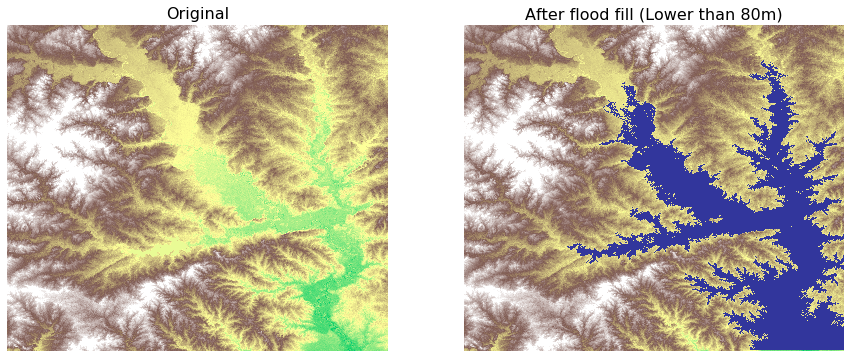

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

da_dem.plot(ax=ax[0],
            cmap=nclcmaps.MPL_terrain,
            vmax=150, vmin=0, 
            add_colorbar=False
           )
ax[0].set_title('Original', fontsize=16)
ax[0].axis('off')

da_flood.plot(ax=ax[1],
              cmap=nclcmaps.MPL_terrain,
              vmax=150, vmin=0, 
              add_colorbar=False
             )
ax[1].set_title('After flood fill (Lower than 80m)', fontsize=16)
ax[1].axis('off')

## References

Teng J, Jakeman A J, Vaze J, et al. Flood inundation modelling: A review of methods, recent advances and uncertainty analysis. Environ Model Softw, 2017, 90: 201-216

Learning Geo Spatial Analysis with Python (v3) by Joel Lawhead (2019)

Travis E, Oliphant. A guide to NumPy, USA: Trelgol Publishing, (2006).

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

https://en.wikipedia.org/wiki/Flood_fill

https://github.com/arijitsaha/FloodRisk